# Question 1

Detection of fake commodity: There are a total of 100,000 pairs of shoes of a well-known brand on an e-commerce platform.

The official guide price of these shoes is 48 ~ 68 dollars. Now we randomly sample 1,000 pairs from them for inspection, where 100 pairs of shoes with quality or <font color='red'>counterfeit problems</font> are found. The price distribution of the 100 pairs of counterfeit shoes is mainly concentrated on two price points, with <font color='red'>60 pairs for 30 dollars</font> and <font color='red'>40 pairs for 50 dollars</font>. 

Please give the price point at which you can most likely buy qualified shoes at the lowest price. Prerequisite judgments can be made based on personal understanding of real life.

In [1]:
from numpy import array, mean, std, arange

def variance_calculator(left_range: int, right_range: int, n: int):
    """
    Calculate the possible variance of a given range.
    left_range: The left side of the interval.
    right_range: The right side of the interval.
    n: The amount of numbers within the range.
    """
    sim_n, diff, mean_p, prices = n, right_range - left_range, mean([left_range, right_range]), []
    for i in range(sim_n + 1):
        prices.append(left_range + i * diff / sim_n)
    prices = array(prices) - mean_p
    print(round(std(prices), 3))

p1, p2 = 48, 68
print("Possible variances are:")
for i in arange(1, 50, 5):
    variance_calculator(p1, p2, i)

Possible variances are:
10.0
6.667
6.276
6.124
6.042
5.991
5.957
5.932
5.913
5.898


# Assumptions
1. The 1,000 samples are uniformly distributed around the official guide price.
2. The shoes with counterfeit problems obeys the normal distribution around the given prices.
3. The shoes below 30 dollars should not be considered. Because that is far less than official price, which means it is far less than costs to production.
4. Only consider the integer prices. The decimals will not change too much, just the accuracy.
5. The variance between products has the maximum of 10.
<br>Because in real life, the variance of the daily necessities will not be high. These commodities are monopolistic competition market stuffs. Furthermore, the official price is around 48-68 dollars, with difference of 20. Therefore, 10 for maximum variance will be reasonable. <font color="sandybrown">According to the result shown above, it also shows that the maximum possible variance is 10.</font>
6. The probabilities of different variance obeys exponential ditribution.
<br>Since the parameter of exponential distribution is estimated according to the Poisson distribution of a related probelm, we can estimate the $\lambda$ parameter according to the probability of counterfeit around price 30 dollars and price 50 dollars as well as the maximum variance assumption.<br>
- For 30 dollars: $\lambda=\frac{60}{10\times2}=3$
- For 50 dollars: $\lambda=\frac{40}{10\times2}=2$
<br>
<br>Therefore, the variance probability around 30 dollars and 50 dollars are $X_{30}\sim Exp(3)$ and $X_{50}\sim Exp(2)$.
7. The distributions range not exceed 20 dollars.
<br>Since the probability exceed 20 dollars will be approach to 0, there is no need to analyze those price in this case.
<br><font color="cornflowerblue">To be specific, the analysis of price lower than 30 dollars will not be included in this analysis, because that far less than the official price.</font>

In [2]:
from scipy.stats import norm
import numpy as np
from timeit import timeit
from tqdm import tqdm
import matplotlib.pyplot as plt

## Settings

In [3]:
# The probability of $30 and $50 counterfeits.
prob30, prob50 = 0.06, 0.04
# The mean of the counterfeit distributions
mu30, mu50 = 30, 50
# The simulation times
sn = 10000
# The lambda value for the $30 and $50 scenario.
lambda30, lambda50 = 3, 2
# The maximum of variance
max_var = 10
# Price range
P30 = np.arange(30, 51)
P50 = np.arange(30, 71)
investigate_P = np.arange(30, 71)

In [4]:
print("$30:", P30)
print("$50:", P50)

$30: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
$50: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]


## Random simulator number generation

In [5]:
def expon_pdf(x: int, lambda_val: int):
    """
    The PDF function of the exponential distribution.
    Get the corresponding probability according to given number and lambda value.
    :params x: The given number.
    :params lambda_val: The lambda value.
    :return: The probability of the given number under given exponential distribution.
    """
    return lambda_val * np.exp(-lambda_val * x) if x >= 0 else 0

def expon_num_gen(lambda_val: int, amt: int, scaler: int, std_scale=True):
    """
    Generate exponential distributed random number according to a given exponential distribution.
    :params lambda_val: The lambda value.
    :params amt: The generated amount of random numbers.
    :params scaler: The target scale, which is the generated object.
    :params std_scale: Whether to scale the generated exponential number to [0, 1] range.
    :return: A list of generated numbers.
    """
    gen_num_list = []
    for i in range(amt):
        x = np.random.rand()
        if std_scale:
            prob = expon_pdf(x, lambda_val) / lambda_val # Scale the probability to [0,1]
        else:
            prob = expon_pdf(x, lambda_val)
        gen_num_list.append(round(prob * scaler, 6))
    return gen_num_list
    
expon_pdf(1, 3)

0.14936120510359183

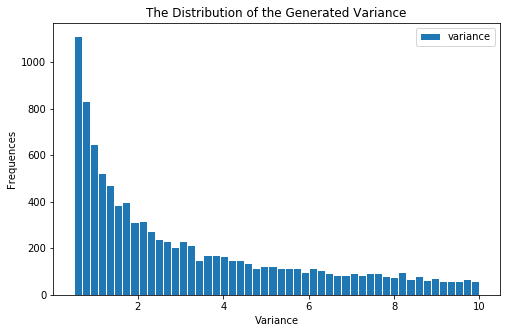

mix:0.497909 max:9.999653


In [6]:
def distribution_gen_variance(gen_list: list, save_fig=False, fig_name="Distrib_variance.png"):
    """
    Graph the distribution of the generated variances.
    :params gen_list: The list of generated numbers.
    :params save_fig: Whether to save the graph.
    :params fig_name: Graph file name.
    """
    fig = plt.figure(figsize=(8, 5))
    plt.hist(gen_list, bins=50, edgecolor="white", label="variance")
    plt.legend()
    plt.xlabel("Variance")
    plt.ylabel("Frequences")
    plt.title("The Distribution of the Generated Variance")
    plt.show()
    print("mix:{} max:{}".format(min(x), max(x)))

x = expon_num_gen(3, 10000, 10)
distribution_gen_variance(x)

## Calculate the probability of counterfeit product on each given price

In [7]:
def price_fake_prob(p: int, mu: float, sigma: float):
    """
    Calculate the possibility of counterfeit on given price point.
    :params p: The given price.
    :params mu: The mean value of the normal distribution.
    :params sigma: The standard deviation of the normal distribution.
    :return: The probability of counterfeit product the given price.
    """
    prob = norm.pdf((p - mu) / sigma)
    return round(prob, 6)

display(price_fake_prob(60, mu50, 1))
display(price_fake_prob(60, mu50, 5))
display(price_fake_prob(60, mu50, 10))

0.0

0.053991

0.241971

In [8]:
# Generate variance list of the $30 and $50 correspondingly.
vars30 = expon_num_gen(lambda30, sn, max_var)
vars50 = expon_num_gen(lambda50, sn, max_var)

In [9]:
# Get the probability of counterfeit products on each possible, wanted to investigate price.
def gen_fake_prob_on_prices(prices: list, variances: list, mu: int):
    """
    Generate the probability of counterfeit products on each price.
    :params prices: The price list to be investigated.
    :params variances: The variance list of the normal distribution.
    :params mu: The mean value of the normal distribution.
    :return: The dictionary of counterfeit product probability on each price.
    """
    p_fake_prob = {}
    for price in tqdm(prices):
        p_fake_prob[price] = [price_fake_prob(price, mu, var) for var in variances]
    return p_fake_prob

p30_fake_prob = gen_fake_prob_on_prices(P30, vars30, mu30)
p50_fake_prob = gen_fake_prob_on_prices(P50, vars50, mu50)

100%|██████████| 41/41 [02:13<00:00,  3.26s/it]


In [10]:
def MCS_price_prob(price_range: list, **kwargs):
    """
    Monte Carlo Simulation to calculate the average probability of counterfeiting on each price.
    :params price_range: The price range list includes all the prices to be investigated.
    :params args: The counterfeit probabilities.
    :return: The simulation estimated probability of each price.
    """
    avg_prob = {}
    for price in price_range:
        group_prob = {}
        for name, prob_dict in kwargs.items():
            prob_list = prob_dict[0].get(price) if prob_dict[0].get(price) is not None else [0]
            mean_prob = mean(prob_list)
            group_prob[name] = mean_prob * prob_dict[1]
        avg_prob[price] = sum(group_prob.values())
        print(f'${price: 3} : {avg_prob[price]: 6f}')
    return avg_prob

avg_prob = MCS_price_prob(investigate_P, price30=[p30_fake_prob, prob30], price50=[p50_fake_prob, prob50])

$ 30 :  0.024131
$ 31 :  0.018887
$ 32 :  0.013696
$ 33 :  0.010664
$ 34 :  0.008625
$ 35 :  0.007165
$ 36 :  0.006103
$ 37 :  0.005345
$ 38 :  0.004836
$ 39 :  0.004545
$ 40 :  0.004454
$ 41 :  0.004559
$ 42 :  0.004864
$ 43 :  0.005384
$ 44 :  0.006149
$ 45 :  0.007211
$ 46 :  0.008659
$ 47 :  0.010598
$ 48 :  0.012980
$ 49 :  0.015216
$ 50 :  0.016147
$ 51 :  0.014967
$ 52 :  0.012655
$ 53 :  0.010175
$ 54 :  0.008115
$ 55 :  0.006514
$ 56 :  0.005261
$ 57 :  0.004261
$ 58 :  0.003451
$ 59 :  0.002791
$ 60 :  0.002250
$ 61 :  0.001806
$ 62 :  0.001444
$ 63 :  0.001148
$ 64 :  0.000908
$ 65 :  0.000713
$ 66 :  0.000557
$ 67 :  0.000432
$ 68 :  0.000333
$ 69 :  0.000255
$ 70 :  0.000194


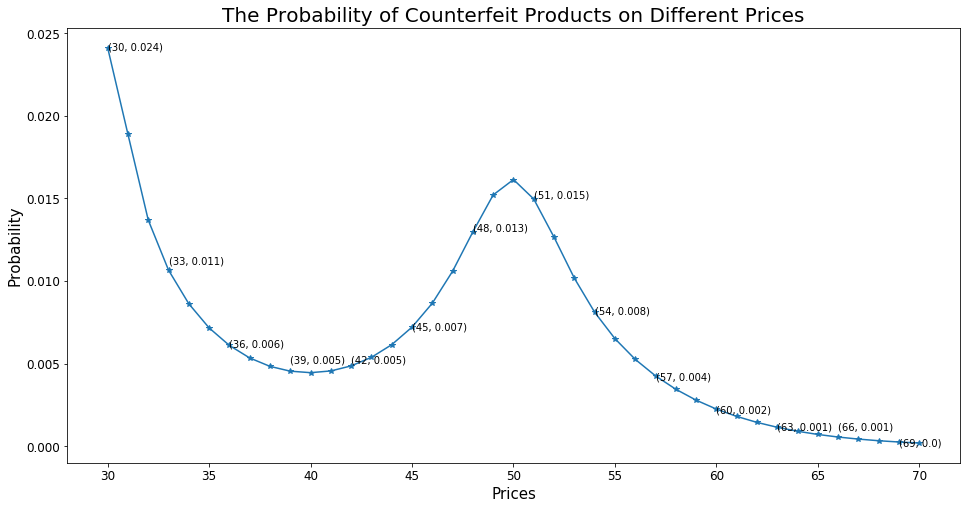

In [11]:
def graph_price_prob_distrib(price_prob: dict, display_p_label=True, interval=1, save_fig=False, figname="Prob_distrib.png"):
    """
    Graph the probability on each price.
    :params price_prob: The price probability dictionary with price as key, probability as values.
    :params display_p_label: Whether to display the point label on the graph.
    :params interval: The intervals for each labeled point.
    :params save_fig: Whether to save the graph.
    :params figname: Graph file name.
    """
    x, y = list(price_prob.keys()), list(price_prob.values())
    fig = plt.figure(figsize=(16, 8))
    plt.plot(x, y, marker="*")
    if display_p_label:
        for e, (a,b) in enumerate(zip(x, y)):
            if e % interval == 0:
                plt.text(a, round(b, 3), (a, round(b, 3)))
    plt.xlabel("Prices", fontsize=15)
    plt.ylabel("Probability", fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title("The Probability of Counterfeit Products on Different Prices", fontsize=20)
    if save_fig:
        plt.savefig(figname)
    else:
        plt.show()

graph_price_prob_distrib(avg_prob, interval=3)

## Find the best probability

In [12]:
def find_best_prob(probability: dict):
    """
    Find the local and global optimized price and corresponding  probabilities.
    :params probs: The dictionary of prices and corresponding probabilities.
    :return: Both the local and global optimized price and corresponding probabilities.
    """
    local_opt, global_opt, local_p, global_p = float("inf"), float("inf"), 0, 0
    for e, (price, prob) in enumerate(probability.items()):
        if local_opt > prob and local_p == e:
            local_opt = prob
            local_p += 1
        if global_opt > prob:
            global_opt = prob
            global_p = e
    prob_list = list(probability.keys())
    return prob_list[local_p - 1], round(local_opt, 4), prob_list[global_p], round(global_opt, 4)

local_price, local_opt, global_price, global_opt = find_best_prob(avg_prob)
print("The optimized local price is {}, and the probability is {}".format(local_price, local_opt))
print("The optimized global price is {}, and the probability is {}".format(global_price, global_opt))

The optimized local price is 40, and the probability is 0.0045
The optimized global price is 70, and the probability is 0.0002
